In [27]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import datetime, os

import os
from tqdm import tqdm
import cv2
import seaborn as sn
import pandas as pd
import random as rn

In [2]:
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [3]:
label_count = {'Human': 34999, 'Blank': 35000, 'Elephant_African': 34999, 'Hog_Red_River': 26069, 'Buffalo_African': 6459, 'Leopard_African': 2142, 'Monkey': 5038, 'Duiker_Blue': 35000, 'Duiker_Red': 34999, 'Porcupine_Brush_Tailed': 13694, 'Rodent': 1358, 'Squirrel': 11348, 'Rat_Giant': 34225, 'Guineafowl_Crested': 1513, 'Duiker_Yellow_Backed': 15436, 'Guineafowl_Black': 12054, 'Mongoose': 5518, 'Rail_Nkulengu': 3269, 'Chimpanzee': 5260, 'Bird': 6649, 'Genet': 3303, 'Gorilla': 1074, 'Pangolin': 872, 'Mongoose_Black_Footed': 1475, 'Mandrillus': 9305, 'Civet_African_Palm': 936, 'Chevrotain_Water': 4713, 'Cat_Golden': 406}

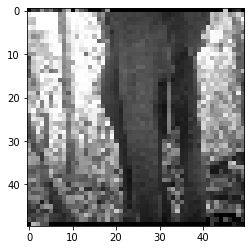

In [4]:
data = np.load("C:/Users/Siebren/Data_science/Data/Data_Gabon/training_data_gabon.npy", allow_pickle=True)
plt.imshow(data[2][0], cmap="gray")
plt.show()

In [5]:
len(data)

347113

In [6]:
# select pictures of each class.
new_data = []
counter = {}
for i in data:
    if i[1] not in counter.keys():
        counter[i[1]] = 0
        
for picture in data:
    if picture[1] == 0:
        new_data.append(picture)
        img = tf.keras.preprocessing.image.img_to_array(data[2][0])  # convert image to numpy arry
        aug_img = tf.image.flip_left_right(img)
        aug_img = tf.reshape(aug_img, picture[0].shape)
        new_data.append([aug_img, picture[1]])
        counter[picture[1]] += 1
    elif picture[1] in counter.keys():
        if counter[picture[1]] != 1400:
            counter[picture[1]] += 1
            picture[1] = 1
            img = tf.keras.preprocessing.image.img_to_array(data[2][0])  # convert image to numpy arry
            aug_img = tf.image.flip_left_right(img)
            aug_img = tf.reshape(aug_img, picture[0].shape)
            new_data.append([aug_img, picture[1]])
            new_data.append(picture)
len(new_data)

140890

In [7]:
# Normalize pixel values to be between 0 and 1
for pictures in data:
    pictures[0] = pictures[0] / 255

In [8]:
# check labels
label_count = {}
for items, labels in new_data:
    if labels in label_count:
        label_count[labels] += 1
    else:
        label_count[labels] = 1
print(label_count)

{1: 70892, 0: 69998}


In [9]:
# get the labels
def get_labels(data):
    images, labels = [], []
    for items in data:
        images.append(items[0])
        labels.append(items[1])
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

images, labels = get_labels(new_data)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [11]:
# reduce dimentions
X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)
X_val = tf.expand_dims(X_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)
y_val = tf.expand_dims(y_test, axis=-1)

# set initializer
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

In [12]:
# creating the model
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=X_train.shape[1:], padding="same", kernel_initializer=initializer, bias_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same", kernel_initializer=initializer, bias_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", kernel_initializer=initializer, bias_initializer=initializer))

model.add(layers.Flatten())
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(180, activation='relu', kernel_initializer=initializer, bias_initializer=initializer))

model.add(layers.Dense(1, activation='sigmoid')) # <---- change ending layers!!!

model.summary()  # summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 180)               1

In [13]:
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# With tensorboard
history = model.fit(X_train, y_train, epochs=10, batch_size = 32,
                    validation_data=(X_val, y_val))

# With tensorboard
# history = model.fit(X_train, y_train, epochs=10, batch_size = 32,
#                     validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

Epoch 1/10
2642/2642 [==============================] - 88s 33ms/step - loss: 0.5525 - accuracy: 0.6827 - val_loss: 0.4687 - val_accuracy: 0.7008
Epoch 2/10
2642/2642 [==============================] - 86s 33ms/step - loss: 0.4622 - accuracy: 0.7031 - val_loss: 0.4552 - val_accuracy: 0.7102
Epoch 3/10
2642/2642 [==============================] - 89s 34ms/step - loss: 0.4468 - accuracy: 0.7097 - val_loss: 0.4467 - val_accuracy: 0.7140
Epoch 4/10
2642/2642 [==============================] - 87s 33ms/step - loss: 0.4314 - accuracy: 0.7145 - val_loss: 0.4254 - val_accuracy: 0.7238
Epoch 5/10
2642/2642 [==============================] - 91s 34ms/step - loss: 0.4150 - accuracy: 0.7265 - val_loss: 0.4156 - val_accuracy: 0.7216
Epoch 6/10
2642/2642 [==============================] - 86s 33ms/step - loss: 0.4028 - accuracy: 0.7311 - val_loss: 0.4091 - val_accuracy: 0.7308
Epoch 7/10
2642/2642 [==============================] - 85s 32ms/step - loss: 0.3899 - accuracy: 0.7326 - val_loss: 0.4095 -

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(test_acc)

881/881 [==============================] - 6s 7ms/step - loss: 0.4078 - accuracy: 0.7287
0.7286890745162964


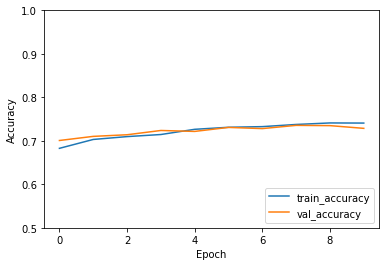

In [15]:
# launch tensorboard
# %tensorboard --logdir logs --host localhost
# %tensorboard --logdir logs 

# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


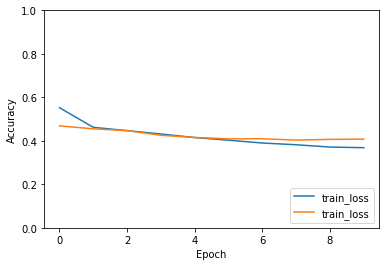

In [16]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [17]:
def pred_values(X_test, y_test):    
    predictions = model.predict(X_test)
    count_zero, count_one = 0, 0
    for label in y_test:
        if label == 0:
            count_zero += 1
        elif label == 1:
            count_one += 1

    correct_classified = {0:0, 1:0}
    for i in range(len(predictions)):
        if int(round(predictions[i][0])) == 0 and y_test[i].numpy()[0] == 0:
            correct_classified[0] += 1
        elif int(round(predictions[i][0])) == 1 and y_test[i].numpy()[0] == 1:
            correct_classified[1] += 1

    print("Human " + str(count_zero) + " / " + str(correct_classified[0]))
    print("Other " + str(count_one) + " / " + str(correct_classified[1]))
    
pred_values(X_test, y_test)

Human 13940 / 13623
Other 14238 / 6910


In [18]:
# model.save('Models/model_V3.h5')

In [19]:
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('Models/model.tflite', 'wb') as f:
#     f.write(tflite_model)

# Test on myanmar data

0


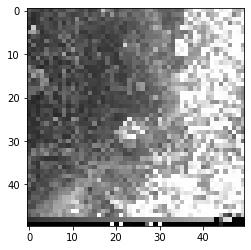

In [20]:
myanmar_data = np.load("C:/Users/Siebren/Data_science/Data/Data_Myanmar/testing_data_myanmar_for_gabon_model.npy", allow_pickle=True)

i = 4
plt.imshow(myanmar_data[i][0], cmap="gray")
print(myanmar_data[i][1])
plt.show()

In [21]:
pictures_myan = []
labels_myan = []

# Normalize pixel values to be between 0 and 1
for pic in myanmar_data:
    pic[0] = pic[0] / 255

for picture_myan, label_myan in myanmar_data:
    if label_myan > 0:
        label_myan = 1
    pictures_myan.append(picture_myan)
    labels_myan.append(label_myan)

In [22]:
pictures_myan = np.array(pictures_myan)
labels_myan = np.array(labels_myan)

pictures_myan = tf.expand_dims(pictures_myan, axis=-1)
labels_myan = tf.expand_dims(labels_myan, axis=-1)

In [23]:
test_loss, test_acc = model.evaluate(pictures_myan, labels_myan, verbose=1)
print(test_acc)

92/92 [==============================] - 1s 5ms/step - loss: 5.5302 - accuracy: 0.1749
0.17486338317394257


In [24]:
pred_values(pictures_myan, labels_myan)

Human 2562 / 189
Other 366 / 323


In [26]:
poachers_data = np.load("C:/Users/Siebren/Data_science/Data/Data_Myanmar/training_data_myanmar.npy", allow_pickle=True)

poachers_img = []
poachers_labels = []

# Normalize pixel values to be between 0 and 1
for pic in poachers_data:
    pic[0] = pic[0] / 255
    
for i in poachers_data:
    if i[1].argmax() == 4:
        i[1] = 0
        poachers_img.append(i[0])
        poachers_labels.append(i[1])

poachers_img  = np.array(poachers_img)
poachers_labels = np.array(poachers_labels)

poachers_img = tf.expand_dims(poachers_img, axis=-1)
poachers_labels = tf.expand_dims(poachers_labels, axis=-1)

pred_values(poachers_img, poachers_labels)

Human 27 / 4
Other 0 / 0
